Copyright by Arjun Sarkar Research Group Applied Systems Biology - Head: Prof. Dr. Marc Thilo Figge https://www.leibniz-hki.de/en/applied-systems-biology.html HKI-Center for Systems Biology of Infection Leibniz Institute for Natural Product Research and Infection Biology - Hans Knöll Insitute (HKI) Adolf-Reichwein-Straße 23, 07745 Jena, Germany

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras import layers
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt
import imageio
import cv2 as cv
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="4,5,6,7"

strategy = tf.distribute.MirroredStrategy(["GPU:0","GPU:1","GPU:2","GPU:3"])

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [3]:
NUM_FEATURES = 2048
MAX_SEQ_LENGTH = 40
IMG_SIZE = 456

In [4]:
#LSTM models

with strategy.scope():
    
    lstm_1 = tf.keras.models.load_model('lstm_1.h5')
    lstm_2 = tf.keras.models.load_model('lstm_2.h5')
    lstm_3 = tf.keras.models.load_model('lstm_3.h5')
    lstm_4 = tf.keras.models.load_model('lstm_4.h5')
    lstm_5 = tf.keras.models.load_model('lstm_5.h5')
    lstm_6 = tf.keras.models.load_model('lstm_6.h5')
    lstm_7 = tf.keras.models.load_model('lstm_7.h5')
    lstm_8 = tf.keras.models.load_model('lstm_8.h5')
    lstm_9 = tf.keras.models.load_model('lstm_9.h5')

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [5]:
class PositionalEmbedding(layers.Layer):
    
    def __init__(self, sequence_length, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim
        )
        self.sequence_length = sequence_length
        self.output_dim = output_dim
        
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'sequence_length': self.sequence_length,
            'output_dim': self.output_dim
        })
        return config

    def call(self, inputs):
        # The inputs are of shape: `(batch_size, frames, num_features)`
        length = tf.shape(inputs)[1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_positions = self.position_embeddings(positions)
        return inputs + embedded_positions

    def compute_mask(self, inputs, mask=None):
        mask = tf.reduce_any(tf.cast(inputs, "bool"), axis=-1)
        return mask
    
class TransformerEncoder(layers.Layer):
    
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=0.3
        )
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation=tf.nn.gelu), layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        
    def get_config(self):

        config = super().get_config().copy()
        config.update({
            'embed_dim': self.embed_dim,
            'dense_dim': self.dense_dim,
            'num_heads': self.num_heads
        })
        return config

    def call(self, inputs, mask=None):
        
        if mask is not None:
            mask = mask[:, tf.newaxis, :]

        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

In [6]:
with strategy.scope():
    
    transformer_1 = tf.keras.models.load_model('Transformer_1.h5',custom_objects={'PositionalEmbedding': PositionalEmbedding,
                                                                     'TransformerEncoder':TransformerEncoder})
    transformer_2 = tf.keras.models.load_model('Transformer_2.h5',custom_objects={'PositionalEmbedding': PositionalEmbedding,
                                                                     'TransformerEncoder':TransformerEncoder})
    transformer_3 = tf.keras.models.load_model('Transformer_3.h5',custom_objects={'PositionalEmbedding': PositionalEmbedding,
                                                                     'TransformerEncoder':TransformerEncoder})
    transformer_4 = tf.keras.models.load_model('Transformer_4.h5',custom_objects={'PositionalEmbedding': PositionalEmbedding,
                                                                     'TransformerEncoder':TransformerEncoder})
    transformer_5 = tf.keras.models.load_model('Transformer_5.h5',custom_objects={'PositionalEmbedding': PositionalEmbedding,
                                                                     'TransformerEncoder':TransformerEncoder})
    transformer_6 = tf.keras.models.load_model('Transformer_6.h5',custom_objects={'PositionalEmbedding': PositionalEmbedding,
                                                                     'TransformerEncoder':TransformerEncoder})
    transformer_7 = tf.keras.models.load_model('Transformer_7.h5',custom_objects={'PositionalEmbedding': PositionalEmbedding,
                                                                     'TransformerEncoder':TransformerEncoder})
    transformer_8 = tf.keras.models.load_model('Transformer_8.h5',custom_objects={'PositionalEmbedding': PositionalEmbedding,
                                                                     'TransformerEncoder':TransformerEncoder})
    transformer_9 = tf.keras.models.load_model('Transformer_9.h5',custom_objects={'PositionalEmbedding': PositionalEmbedding,
                                                                     'TransformerEncoder':TransformerEncoder})

In [7]:
df = pd.read_csv('Labels.csv')
df = df.rename(columns={'Inefction_type':'infection'})
df.head()

,Video_Num,infection,Patient,Patient_id
0,1,ca,1,20180220
1,2,cg,1,20180220
2,3,mock,1,20180220
3,4,ca,2,20180315
4,5,cg,2,20180315


In [8]:
test_1 = df[(df['Patient']==1)]
test_2 = df[(df['Patient']==2)]
test_3 = df[(df['Patient']==5)]
test_4 = df[(df['Patient']==7)]
test_5 = df[(df['Patient']==8)]
test_6 = df[(df['Patient']==9)]
test_7 = df[(df['Patient']==10)]
test_8 = df[(df['Patient']==11)]
test_9 = df[(df['Patient']==12)]

In [9]:
target_names = ["$\it{C. albicans}$","$\it{C. glabrata}$","Mock"]

def confusion_matrix_(original_label,predicted_label,target_names, num, network):
    
    cm = confusion_matrix(original_label,predicted_label)
    cmn = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(6,6))
    sns.set(font_scale = 1.5)
    image_cm = sns.heatmap(cm, cmap="flare",linewidths= 0.5,
            annot=True,xticklabels=target_names, yticklabels=target_names, cbar=0)
    plt.ylabel('True Labels', fontsize = 18)
    plt.xlabel('Predicted Labels', fontsize = 18)
    plt.xticks(rotation = 45, fontsize = 17)
    plt.yticks(rotation = 45,fontsize = 17)
    plt.title(f'Confusion Matrix {network}', fontsize=20)
    plt.show(block=True)
    image_cm.figure.savefig(f'confusion_matrices/{network}_'+str(num)+'.png',dpi=300,bbox_inches='tight')
    
def confusion_matrix_norm(original_label_all,predicted_label_all,target_names,num, network):
    
    cm = confusion_matrix(original_label_all,predicted_label_all)
    cmn = np.round(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis], decimals=2)
    fig, ax = plt.subplots(figsize=(6,6))
    sns.set(font_scale = 1.5)
    image_cm=sns.heatmap(cmn, cmap="flare",linewidths= 0.5,
            annot=True,xticklabels=target_names, yticklabels=target_names, cbar=0)
    plt.ylabel('True Labels', fontsize = 18)
    plt.xlabel('Predicted Labels', fontsize = 18)
    plt.xticks(rotation = 45, fontsize = 17)
    plt.yticks(rotation = 45,fontsize = 17)
    plt.title(f'Confusion Matrix Normalized {network}', fontsize=20)
    plt.show(block=True)
    image_cm.figure.savefig(f'confusion_matrices/Normalized_{network}_'+str(num)+'.png',dpi=300,bbox_inches='tight')
    
def confusion_matrix_all(original_label_all,predicted_label_all,target_names,num, network):
    
    cm = confusion_matrix(original_label_all,predicted_label_all)
    fig, ax = plt.subplots(figsize=(6,6))
    sns.set(font_scale = 1.5)
    image_cm = sns.heatmap(cm, cmap="flare",linewidths= 0.5,
            annot=True,fmt='g',xticklabels=target_names, yticklabels=target_names, cbar=0)
    plt.ylabel('True Labels', fontsize = 18)
    plt.xlabel('Predicted Labels', fontsize = 18)
    plt.xticks(rotation = 45, fontsize = 17)
    plt.yticks(rotation = 45,fontsize = 17)
    plt.title(f'Confusion Matrix All Videos {network}', fontsize=20)
    plt.show(block=True)
    image_cm.figure.savefig(f'confusion_matrices/All_{network}_'+str(num)+'.png',dpi=300,bbox_inches='tight')

In [10]:
def concat_arrays(df):

    full_features = []
    full_labels = []

    for i,item in df.iterrows():
    
        features = np.load(f'/asbdata/Arjun/Bloodi/Patch_videos_numpy/videos/{item[0]}_features.npy')
        labels = np.load(f'/asbdata/Arjun/Bloodi/Patch_videos_numpy/labels/{item[0]}_labels.npy')
    
        full_features.extend(features)
        full_labels.extend(labels)
    
    final_features = np.array(full_features)
    final_labels = np.array(full_labels)
    
    return final_features,final_labels

In [11]:
def find_preds(array):
    
    list_preds = []
    preds = []
    
    for i in range(array.shape[0]):
        for j in range(array.shape[1]):
        
            preds = np.append(preds,array[i,j])
        
        preds = np.array(preds)
        
        unique, occ = np.unique(preds, return_counts=True)
        preds = []
        id_occ = np.argmax(occ)
        final_pred = unique[id_occ]
    
        list_preds = np.append(list_preds,final_pred)
        list_preds = np.array(list_preds)
        list_preds = list_preds.astype(int)
        
    return list_preds

### Donor 1

5/5 [==============================] - 5s 5ms/step


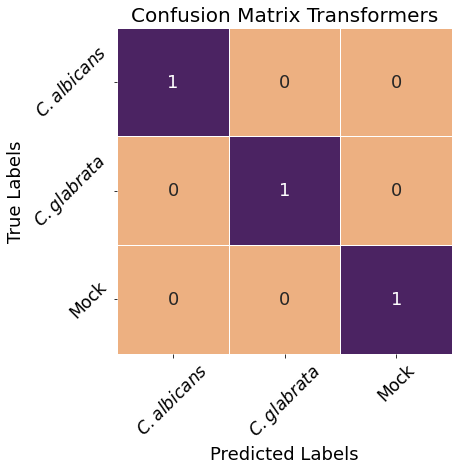

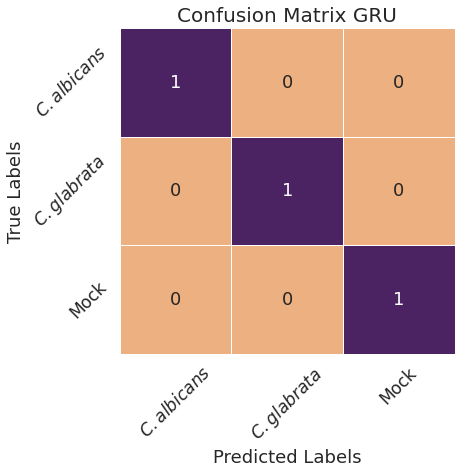

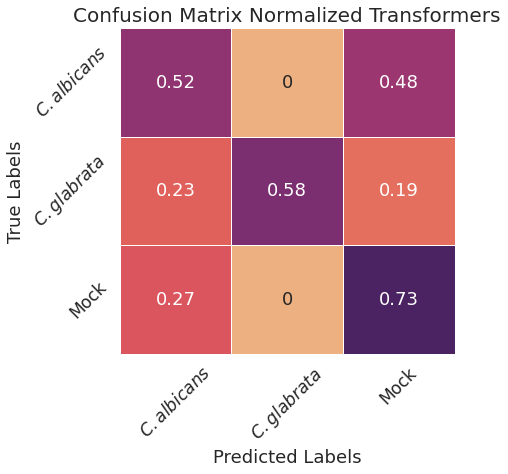

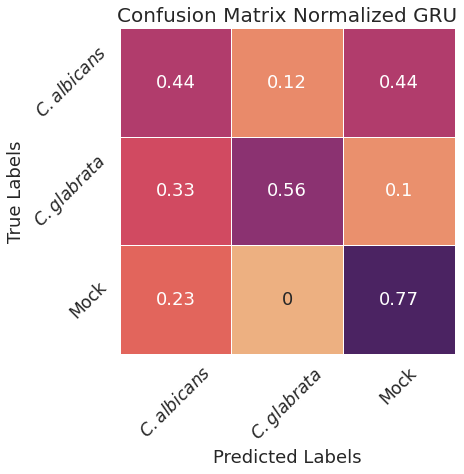

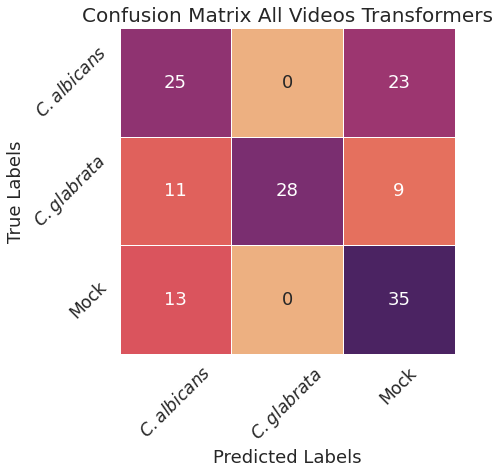

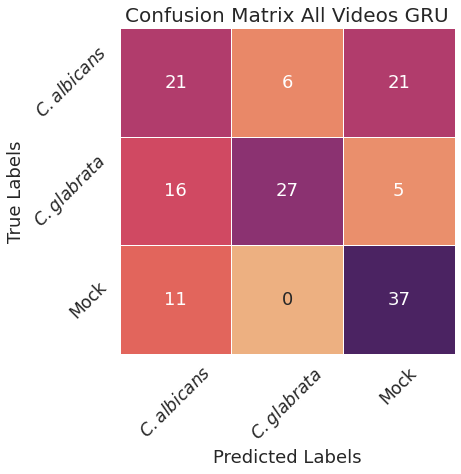

In [12]:
test_data_1, test_labels_1 = concat_arrays(test_1)

predicted_vals_trans_1 = transformer_1.predict(test_data_1).argmax(axis=1)
predicted_vals_lstm_1 = lstm_1.predict(test_data_1).argmax(axis=1)

predicted_trans_1 = np.reshape(predicted_vals_trans_1, (-1,48))
predicted_trans_1 = find_preds(predicted_trans_1)
predicted_lstm_1 = np.reshape(predicted_vals_lstm_1,(-1,48))
predicted_lstm_1 = find_preds(predicted_lstm_1)
labels_1 = np.reshape(test_labels_1,(-1,48))
labels_1 = find_preds(labels_1)

confusion_matrix_(labels_1,predicted_trans_1, target_names, '1', 'Transformers')
confusion_matrix_(labels_1,predicted_lstm_1, target_names, '1', 'GRU')

confusion_matrix_norm(test_labels_1,predicted_vals_trans_1, target_names, '1', 'Transformers')
confusion_matrix_norm(test_labels_1,predicted_vals_lstm_1, target_names, '1', 'GRU')

confusion_matrix_all(test_labels_1,predicted_vals_trans_1, target_names, '1', 'Transformers')
confusion_matrix_all(test_labels_1,predicted_vals_lstm_1, target_names, '1', 'GRU')

### Donor 2

5/5 [==============================] - 3s 5ms/step


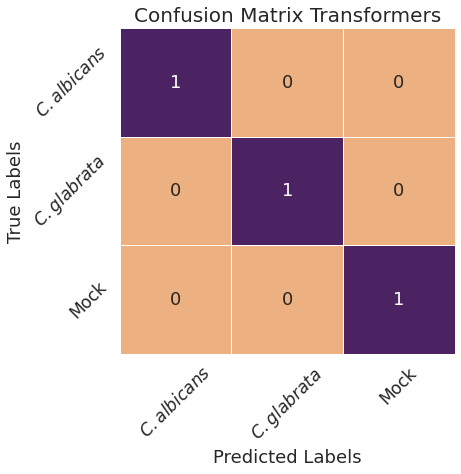

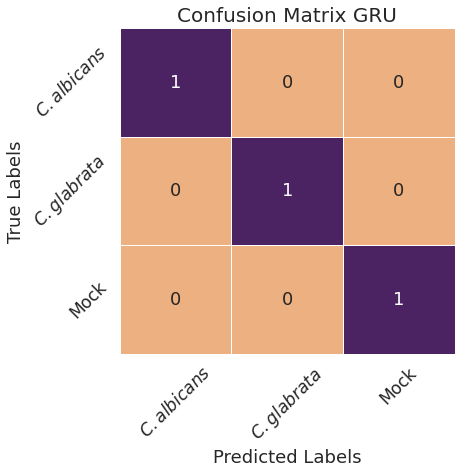

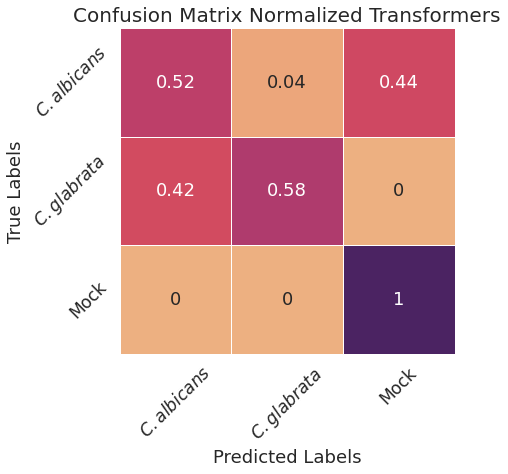

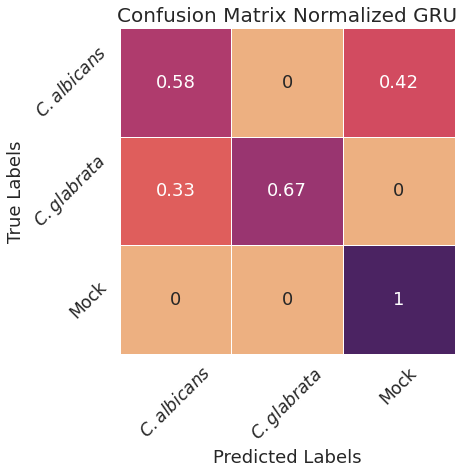

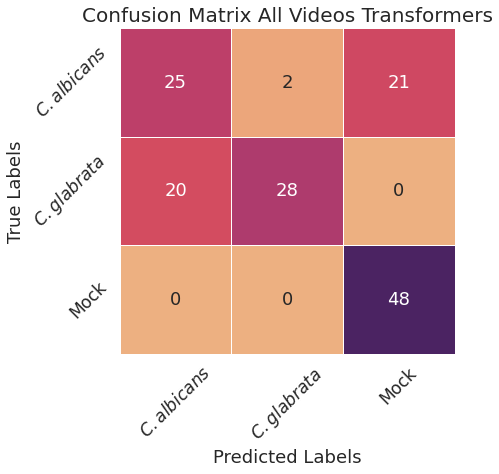

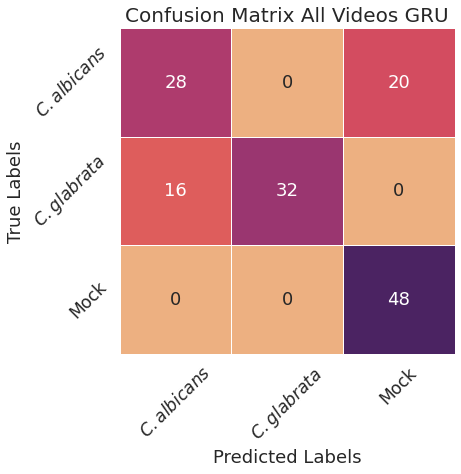

In [13]:
test_data_2, test_labels_2 = concat_arrays(test_2)

predicted_vals_trans_2 = transformer_2.predict(test_data_2).argmax(axis=1)
predicted_vals_lstm_2 = lstm_2.predict(test_data_2).argmax(axis=1)

predicted_trans_2 = np.reshape(predicted_vals_trans_2, (-1,48))
predicted_trans_2 = find_preds(predicted_trans_2)
predicted_lstm_2 = np.reshape(predicted_vals_lstm_2,(-1,48))
predicted_lstm_2 = find_preds(predicted_lstm_2)
labels_2 = np.reshape(test_labels_2,(-1,48))
labels_2 = find_preds(labels_2)

confusion_matrix_(labels_2,predicted_trans_2, target_names, '2', 'Transformers')
confusion_matrix_(labels_2,predicted_lstm_2, target_names, '2', 'GRU')

confusion_matrix_norm(test_labels_2,predicted_vals_trans_2, target_names, '2', 'Transformers')
confusion_matrix_norm(test_labels_2,predicted_vals_lstm_2, target_names, '2', 'GRU')

confusion_matrix_all(test_labels_2,predicted_vals_trans_2, target_names, '2', 'Transformers')
confusion_matrix_all(test_labels_2,predicted_vals_lstm_2, target_names, '2', 'GRU')

### Donor 3

5/5 [==============================] - 3s 4ms/step


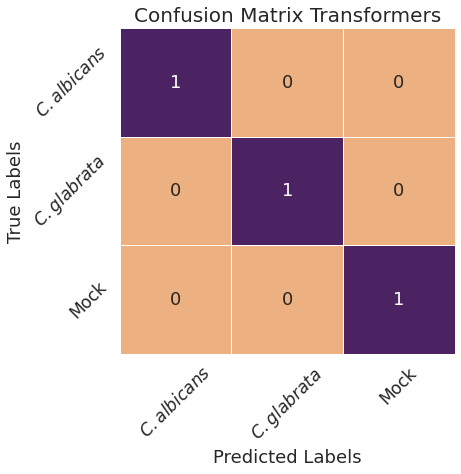

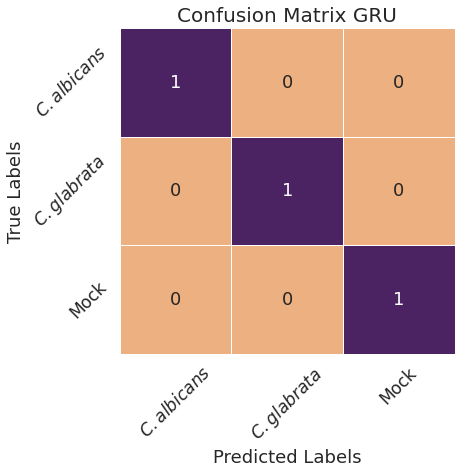

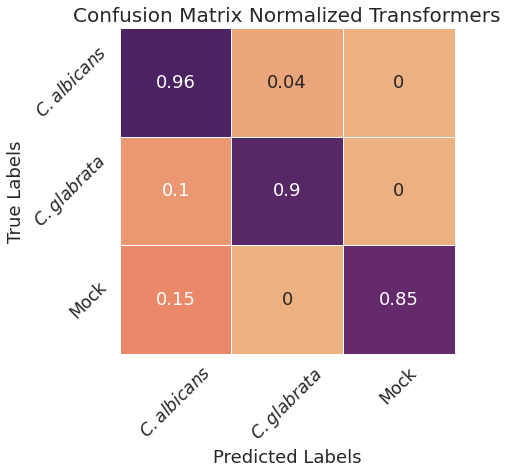

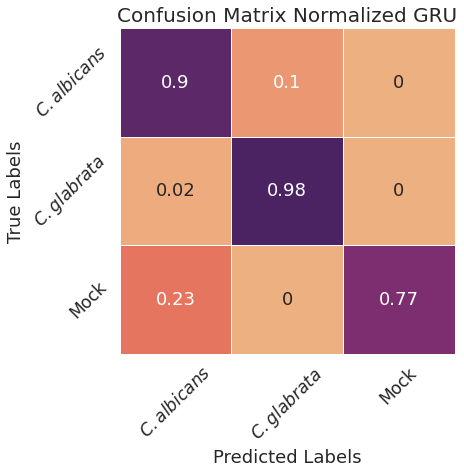

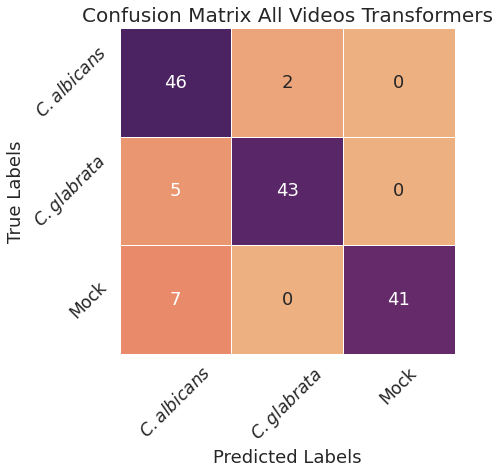

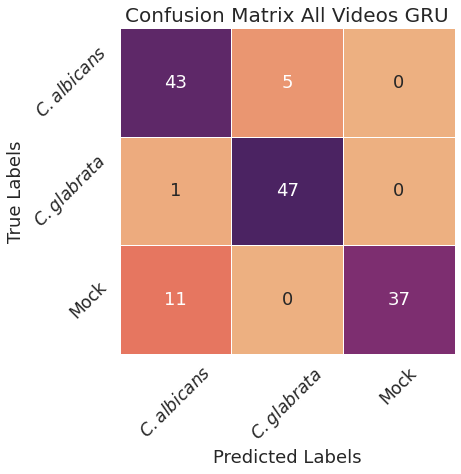

In [14]:
test_data_3, test_labels_3 = concat_arrays(test_3)

predicted_vals_trans_3 = transformer_3.predict(test_data_3).argmax(axis=1)
predicted_vals_lstm_3 = lstm_3.predict(test_data_3).argmax(axis=1)

predicted_trans_3 = np.reshape(predicted_vals_trans_3, (-1,48))
predicted_trans_3 = find_preds(predicted_trans_3)
predicted_lstm_3 = np.reshape(predicted_vals_lstm_3,(-1,48))
predicted_lstm_3 = find_preds(predicted_lstm_3)
labels_3 = np.reshape(test_labels_3,(-1,48))
labels_3 = find_preds(labels_3)

confusion_matrix_(labels_3,predicted_trans_3, target_names, '3', 'Transformers')
confusion_matrix_(labels_3,predicted_lstm_3, target_names, '3', 'GRU')

confusion_matrix_norm(test_labels_3,predicted_vals_trans_3, target_names, '3', 'Transformers')
confusion_matrix_norm(test_labels_3,predicted_vals_lstm_3, target_names, '3', 'GRU')

confusion_matrix_all(test_labels_3,predicted_vals_trans_3, target_names, '3', 'Transformers')
confusion_matrix_all(test_labels_3,predicted_vals_lstm_3, target_names, '3', 'GRU')

### Donor 4

5/5 [==============================] - 3s 5ms/step


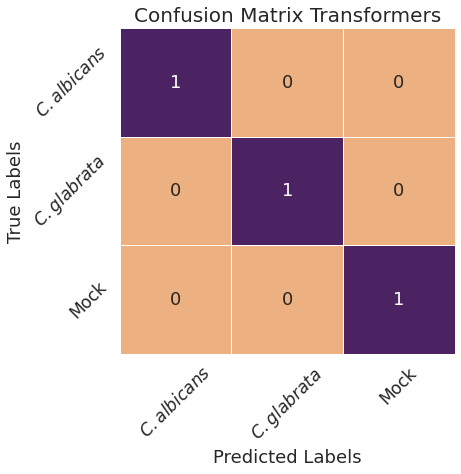

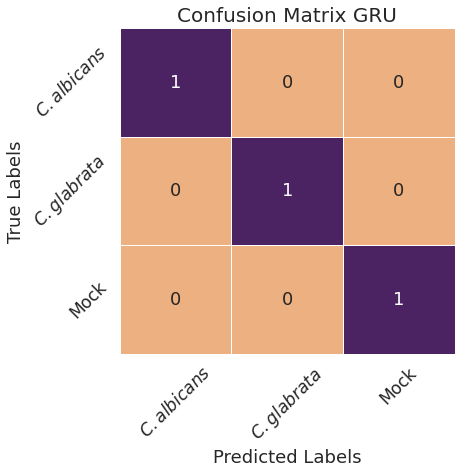

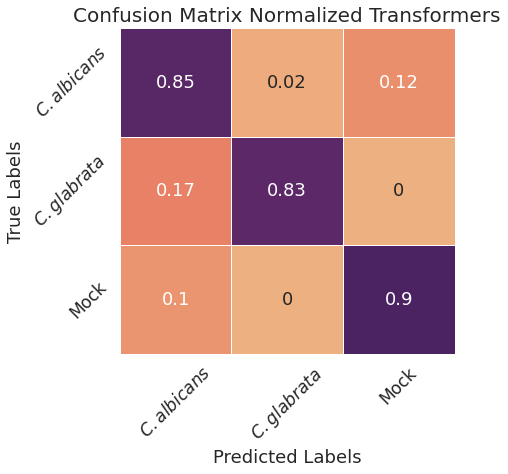

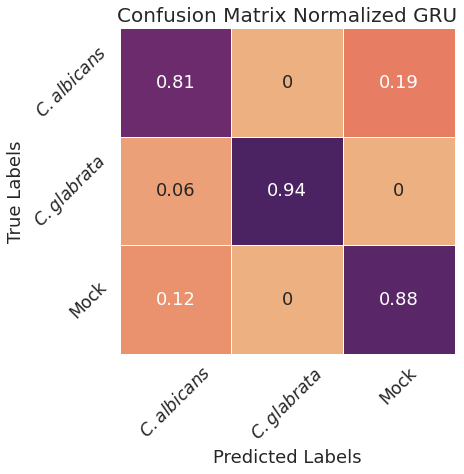

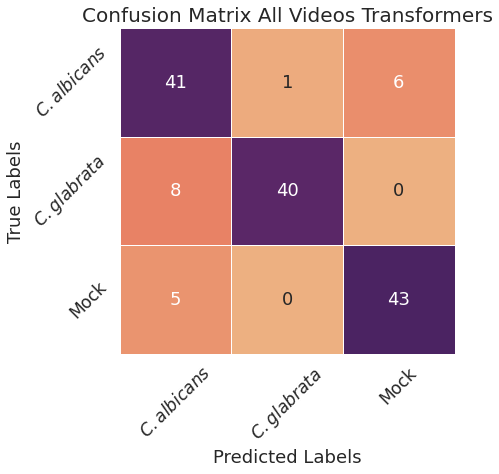

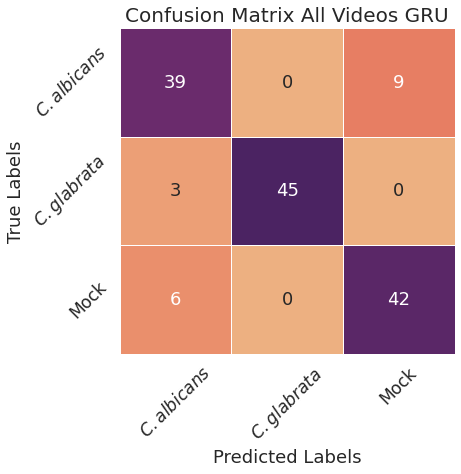

In [15]:
test_data_4, test_labels_4 = concat_arrays(test_4)

predicted_vals_trans_4 = transformer_4.predict(test_data_4).argmax(axis=1)
predicted_vals_lstm_4 = lstm_4.predict(test_data_4).argmax(axis=1)

predicted_trans_4 = np.reshape(predicted_vals_trans_4, (-1,48))
predicted_trans_4 = find_preds(predicted_trans_4)
predicted_lstm_4 = np.reshape(predicted_vals_lstm_4,(-1,48))
predicted_lstm_4 = find_preds(predicted_lstm_4)
labels_4 = np.reshape(test_labels_4,(-1,48))
labels_4 = find_preds(labels_4)

confusion_matrix_(labels_4,predicted_trans_4, target_names, '2', 'Transformers')
confusion_matrix_(labels_4,predicted_lstm_4, target_names, '2', 'GRU')

confusion_matrix_norm(test_labels_4,predicted_vals_trans_4, target_names, '2', 'Transformers')
confusion_matrix_norm(test_labels_4,predicted_vals_lstm_4, target_names, '2', 'GRU')

confusion_matrix_all(test_labels_4,predicted_vals_trans_4, target_names, '2', 'Transformers')
confusion_matrix_all(test_labels_4,predicted_vals_lstm_4, target_names, '2', 'GRU')

### Donor 5

5/5 [==============================] - 3s 4ms/step


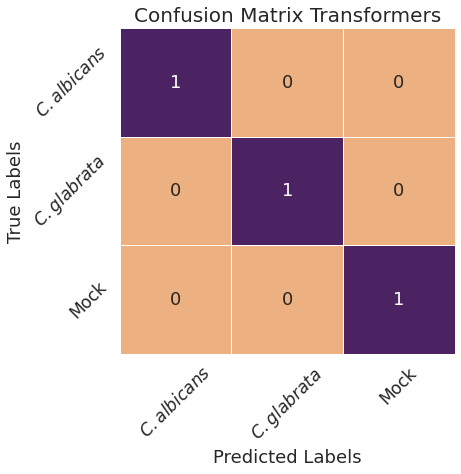

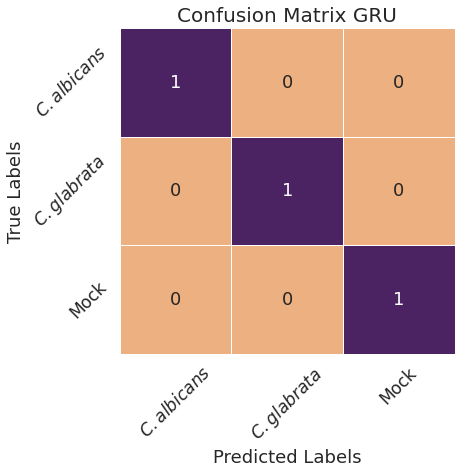

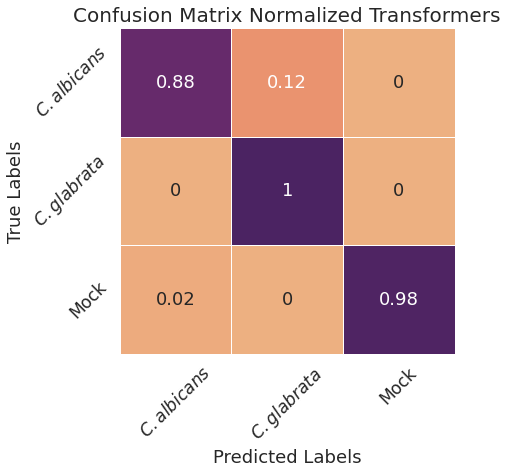

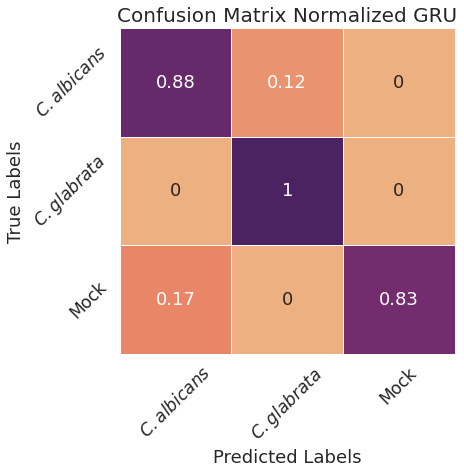

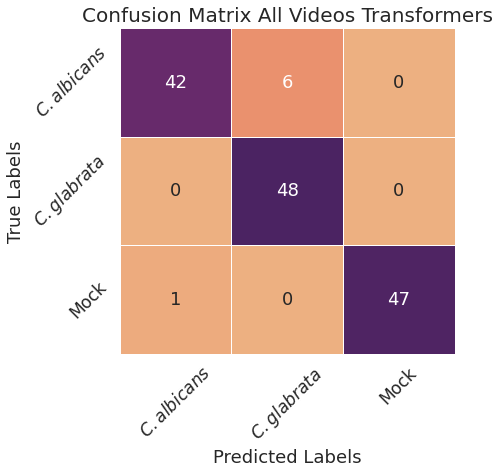

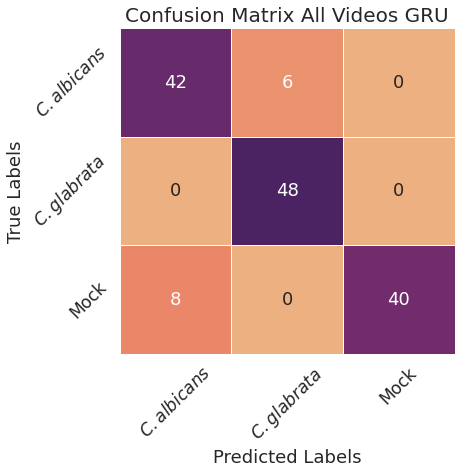

In [16]:
test_data_5, test_labels_5 = concat_arrays(test_5)

predicted_vals_trans_5 = transformer_5.predict(test_data_5).argmax(axis=1)
predicted_vals_lstm_5 = lstm_5.predict(test_data_5).argmax(axis=1)

predicted_trans_5 = np.reshape(predicted_vals_trans_5, (-1,48))
predicted_trans_5 = find_preds(predicted_trans_5)
predicted_lstm_5 = np.reshape(predicted_vals_lstm_5,(-1,48))
predicted_lstm_5 = find_preds(predicted_lstm_5)
labels_5 = np.reshape(test_labels_5,(-1,48))
labels_5 = find_preds(labels_5)

confusion_matrix_(labels_5,predicted_trans_5, target_names, '5', 'Transformers')
confusion_matrix_(labels_5,predicted_lstm_5, target_names, '5', 'GRU')

confusion_matrix_norm(test_labels_5,predicted_vals_trans_5, target_names, '5', 'Transformers')
confusion_matrix_norm(test_labels_5,predicted_vals_lstm_5, target_names, '5', 'GRU')

confusion_matrix_all(test_labels_5,predicted_vals_trans_5, target_names, '5', 'Transformers')
confusion_matrix_all(test_labels_5,predicted_vals_lstm_5, target_names, '5', 'GRU')

### Donor 6

5/5 [==============================] - 3s 4ms/step


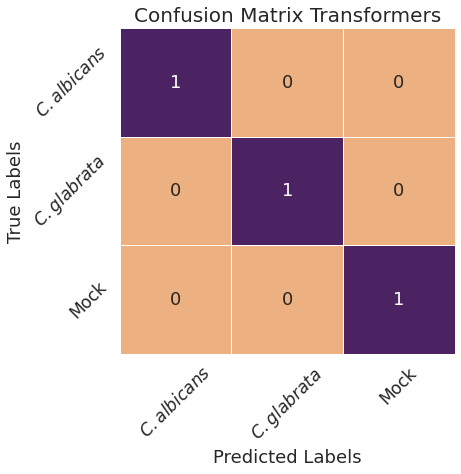

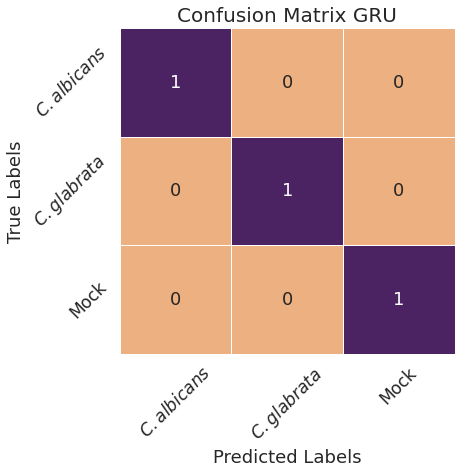

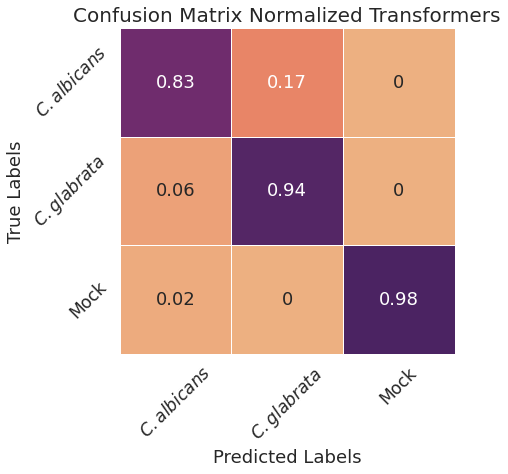

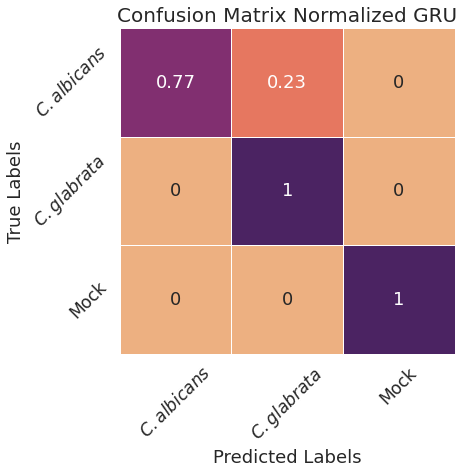

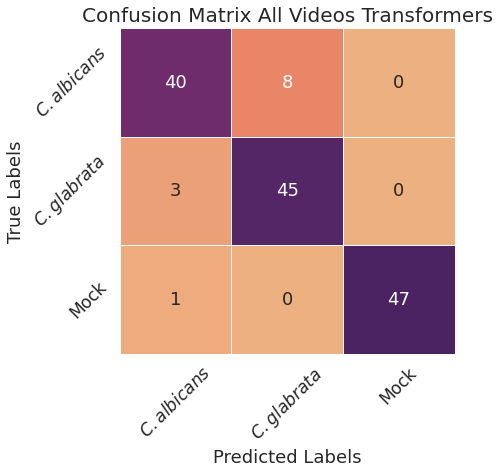

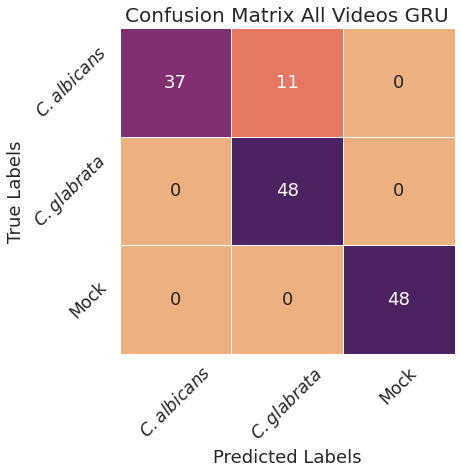

In [17]:
test_data_6, test_labels_6 = concat_arrays(test_6)

predicted_vals_trans_6 = transformer_6.predict(test_data_6).argmax(axis=1)
predicted_vals_lstm_6 = lstm_6.predict(test_data_6).argmax(axis=1)

predicted_trans_6 = np.reshape(predicted_vals_trans_6, (-1,48))
predicted_trans_6 = find_preds(predicted_trans_6)
predicted_lstm_6 = np.reshape(predicted_vals_lstm_6,(-1,48))
predicted_lstm_6 = find_preds(predicted_lstm_6)
labels_6 = np.reshape(test_labels_6,(-1,48))
labels_6 = find_preds(labels_6)

confusion_matrix_(labels_6,predicted_trans_6, target_names, '6', 'Transformers')
confusion_matrix_(labels_6,predicted_lstm_6, target_names, '6', 'GRU')

confusion_matrix_norm(test_labels_6,predicted_vals_trans_6, target_names, '6', 'Transformers')
confusion_matrix_norm(test_labels_6,predicted_vals_lstm_6, target_names, '6', 'GRU')

confusion_matrix_all(test_labels_6,predicted_vals_trans_6, target_names, '6', 'Transformers')
confusion_matrix_all(test_labels_6,predicted_vals_lstm_6, target_names, '6', 'GRU')

### Donor 7

5/5 [==============================] - 3s 5ms/step


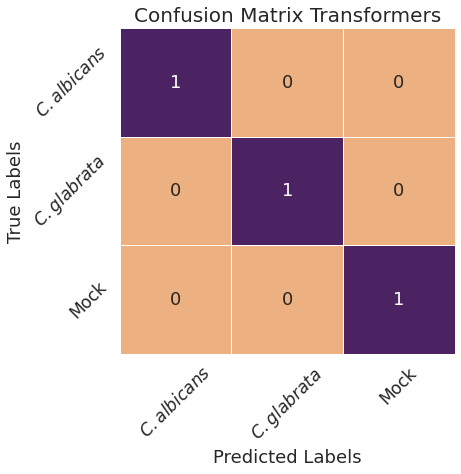

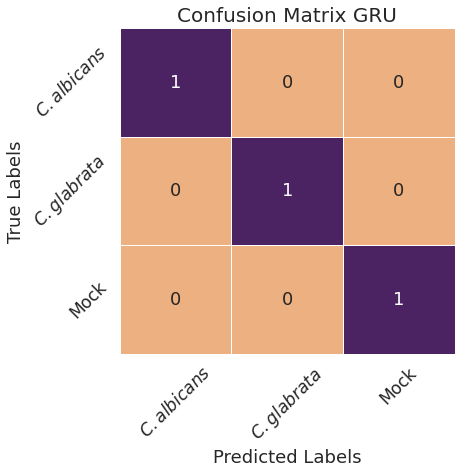

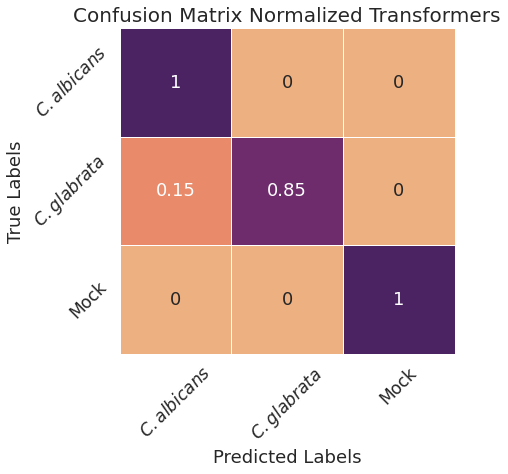

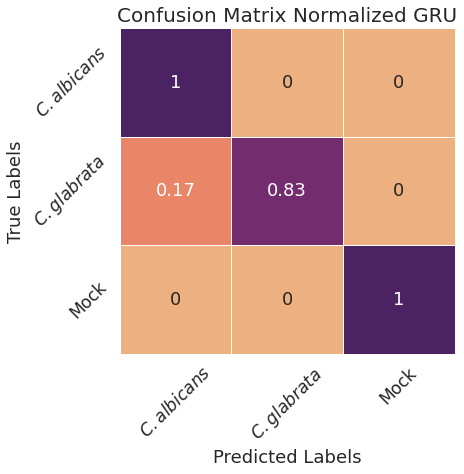

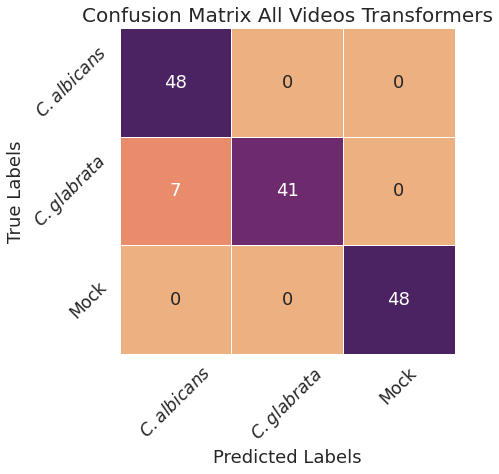

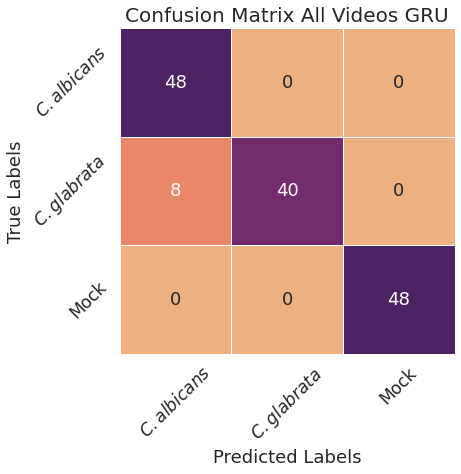

In [18]:
test_data_7, test_labels_7 = concat_arrays(test_7)

predicted_vals_trans_7 = transformer_7.predict(test_data_7).argmax(axis=1)
predicted_vals_lstm_7 = lstm_7.predict(test_data_7).argmax(axis=1)

predicted_trans_7 = np.reshape(predicted_vals_trans_7, (-1,48))
predicted_trans_7 = find_preds(predicted_trans_7)
predicted_lstm_7 = np.reshape(predicted_vals_lstm_7,(-1,48))
predicted_lstm_7 = find_preds(predicted_lstm_7)
labels_7 = np.reshape(test_labels_7,(-1,48))
labels_7 = find_preds(labels_7)

confusion_matrix_(labels_7,predicted_trans_7, target_names, '7', 'Transformers')
confusion_matrix_(labels_7,predicted_lstm_7, target_names, '7', 'GRU')

confusion_matrix_norm(test_labels_7,predicted_vals_trans_7, target_names, '7', 'Transformers')
confusion_matrix_norm(test_labels_7,predicted_vals_lstm_7, target_names, '7', 'GRU')

confusion_matrix_all(test_labels_7,predicted_vals_trans_7, target_names, '7', 'Transformers')
confusion_matrix_all(test_labels_7,predicted_vals_lstm_7, target_names, '7', 'GRU')

### Donor 8

5/5 [==============================] - 3s 5ms/step


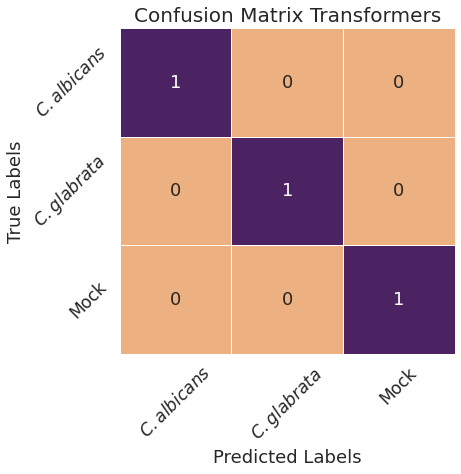

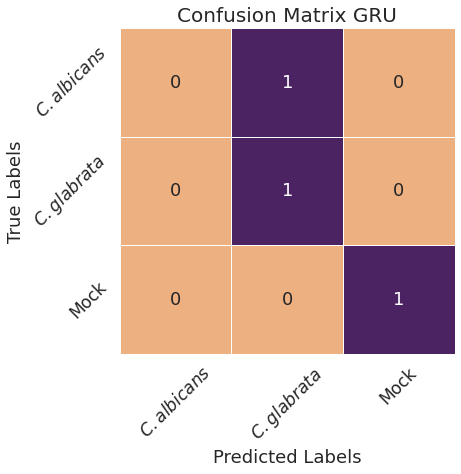

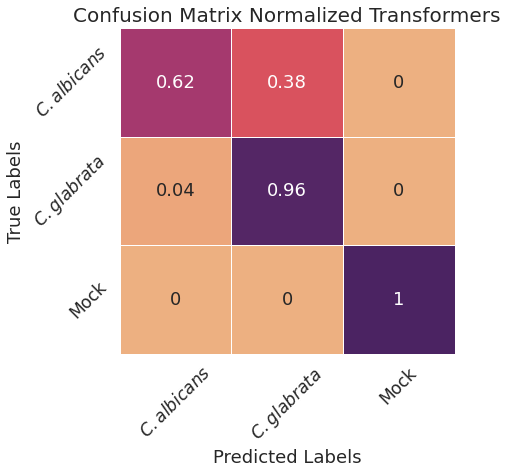

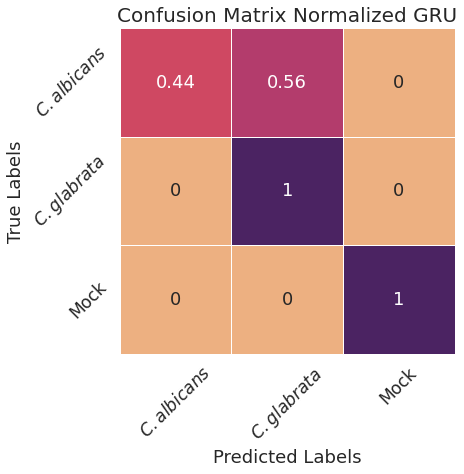

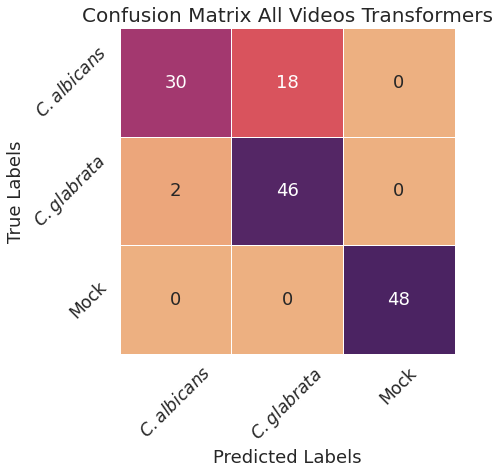

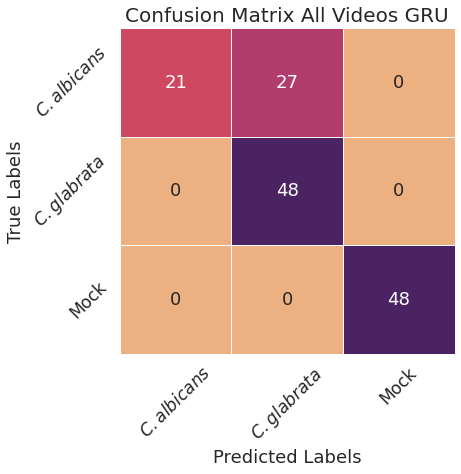

In [19]:
test_data_8, test_labels_8 = concat_arrays(test_8)

predicted_vals_trans_8 = transformer_8.predict(test_data_8).argmax(axis=1)
predicted_vals_lstm_8 = lstm_8.predict(test_data_8).argmax(axis=1)

predicted_trans_8 = np.reshape(predicted_vals_trans_8, (-1,48))
predicted_trans_8 = find_preds(predicted_trans_8)
predicted_lstm_8 = np.reshape(predicted_vals_lstm_8,(-1,48))
predicted_lstm_8 = find_preds(predicted_lstm_8)
labels_8 = np.reshape(test_labels_8,(-1,48))
labels_8 = find_preds(labels_8)

confusion_matrix_(labels_8,predicted_trans_8, target_names, '8', 'Transformers')
confusion_matrix_(labels_8,predicted_lstm_8, target_names, '8', 'GRU')

confusion_matrix_norm(test_labels_8,predicted_vals_trans_8, target_names, '8', 'Transformers')
confusion_matrix_norm(test_labels_8,predicted_vals_lstm_8, target_names, '8', 'GRU')

confusion_matrix_all(test_labels_8,predicted_vals_trans_8, target_names, '8', 'Transformers')
confusion_matrix_all(test_labels_8,predicted_vals_lstm_8, target_names, '8', 'GRU')

### Donor 9

5/5 [==============================] - 3s 5ms/step


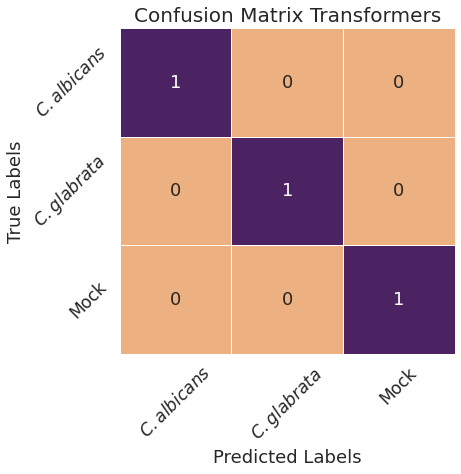

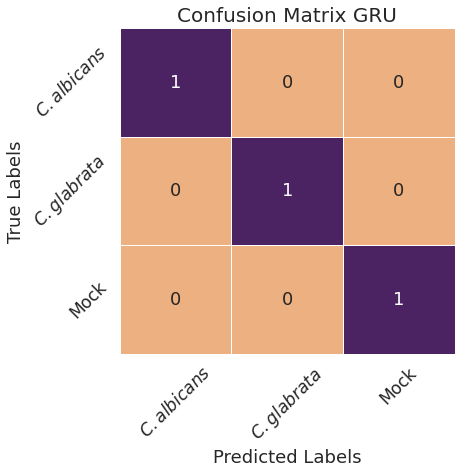

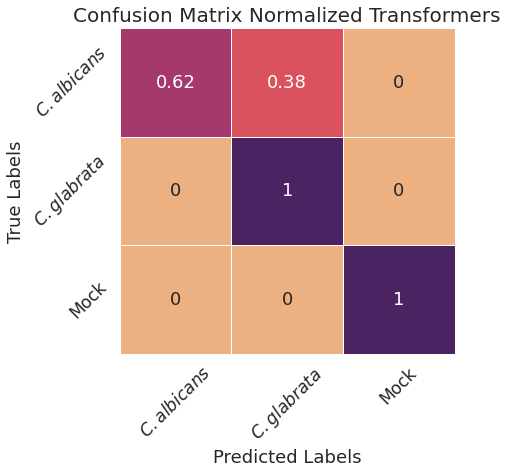

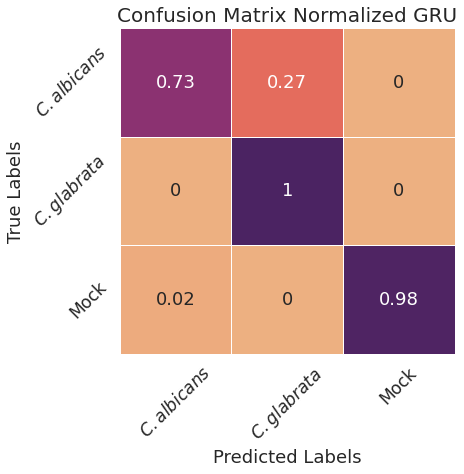

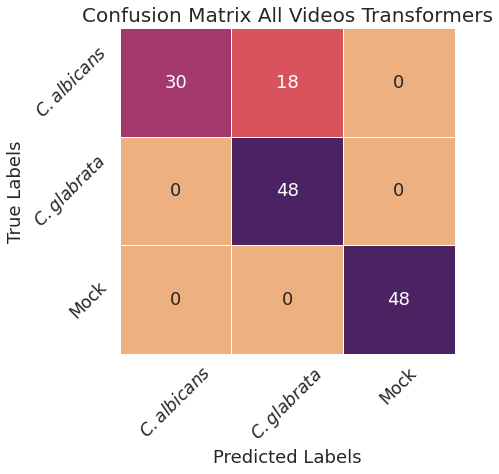

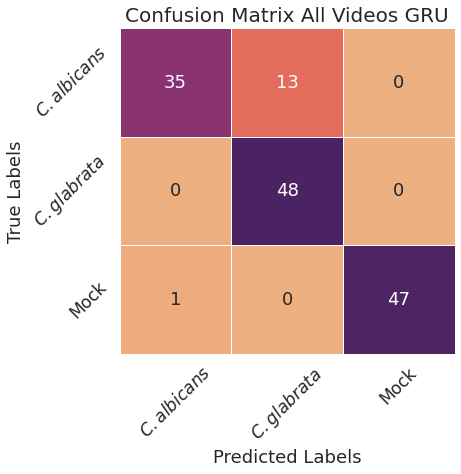

In [20]:
test_data_9, test_labels_9 = concat_arrays(test_9)

predicted_vals_trans_9 = transformer_9.predict(test_data_9).argmax(axis=1)
predicted_vals_lstm_9 = lstm_9.predict(test_data_9).argmax(axis=1)

predicted_trans_9 = np.reshape(predicted_vals_trans_9, (-1,48))
predicted_trans_9 = find_preds(predicted_trans_9)
predicted_lstm_9 = np.reshape(predicted_vals_lstm_9,(-1,48))
predicted_lstm_9 = find_preds(predicted_lstm_9)
labels_9 = np.reshape(test_labels_9,(-1,48))
labels_9 = find_preds(labels_9)

confusion_matrix_(labels_9,predicted_trans_9, target_names, '9', 'Transformers')
confusion_matrix_(labels_9,predicted_lstm_9, target_names, '9', 'GRU')

confusion_matrix_norm(test_labels_9,predicted_vals_trans_9, target_names, '9', 'Transformers')
confusion_matrix_norm(test_labels_9,predicted_vals_lstm_9, target_names, '9', 'GRU')

confusion_matrix_all(test_labels_9,predicted_vals_trans_9, target_names, '9', 'Transformers')
confusion_matrix_all(test_labels_9,predicted_vals_lstm_9, target_names, '9', 'GRU')

### All Donors Combined

In [21]:
donors = [1,2,3,4,5,6,7,8,9]

test_labels = []

for i in donors:
    test_labels.extend(eval('labels_'+str(i)))
    
orig = np.array(test_labels)
orig

array([0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0,
       1, 2, 0, 1, 2])

In [22]:
pred_labels_trans = []

for i in donors:
    pred_labels_trans.extend(eval('predicted_trans_'+str(i)))
    
pred_trans = np.array(pred_labels_trans)
pred_trans

array([0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0,
       1, 2, 0, 1, 2])

In [23]:
pred_labels_lstm = []

for i in donors:
    pred_labels_lstm.extend(eval('predicted_lstm_'+str(i)))
    
pred_lstm = np.array(pred_labels_lstm)
pred_lstm

array([0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 0, 1, 2, 1,
       1, 2, 0, 1, 2])

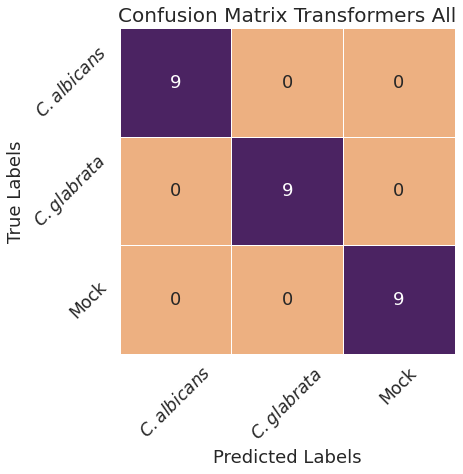

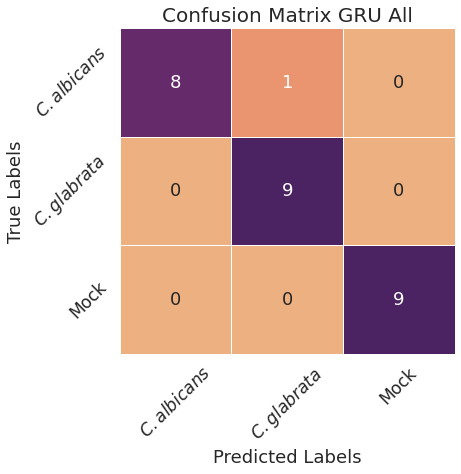

In [24]:
confusion_matrix_(orig,pred_trans, target_names, '0', 'Transformers All')
confusion_matrix_(orig,pred_lstm, target_names, '0', 'GRU All')

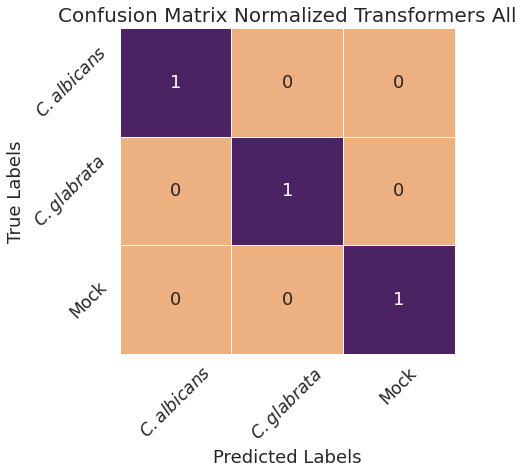

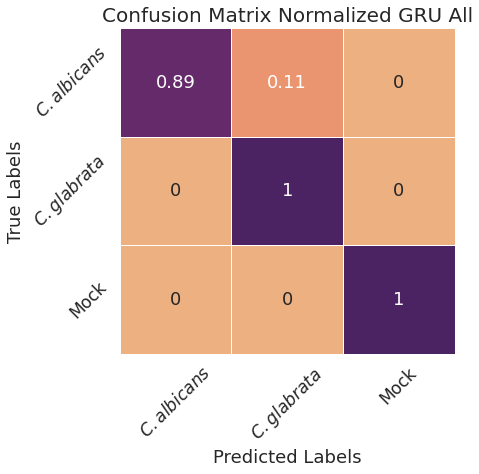

In [25]:
confusion_matrix_norm(orig,pred_trans, target_names, '0', 'Transformers All')
confusion_matrix_norm(orig,pred_lstm, target_names, '0', 'GRU All')

In [26]:
test_labels_all = []

for i in donors:
    test_labels_all.extend(eval('test_labels_'+str(i)))
    
orig_all = np.array(test_labels_all)

pred_labels_trans_all = []

for i in donors:
    pred_labels_trans_all.extend(eval('predicted_vals_trans_'+str(i)))
    
pred_trans_all = np.array(pred_labels_trans_all)

pred_labels_lstm_all = []

for i in donors:
    pred_labels_lstm_all.extend(eval('predicted_vals_lstm_'+str(i)))
    
pred_lstm_all = np.array(pred_labels_lstm_all)

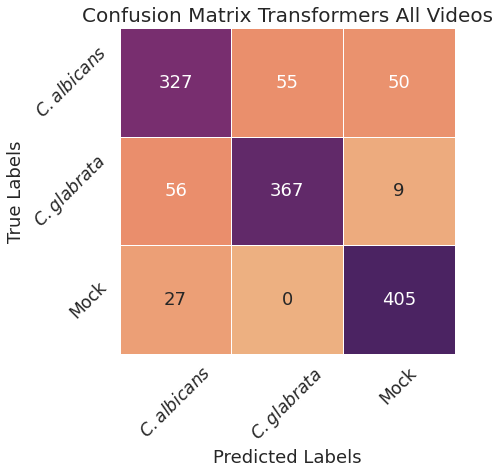

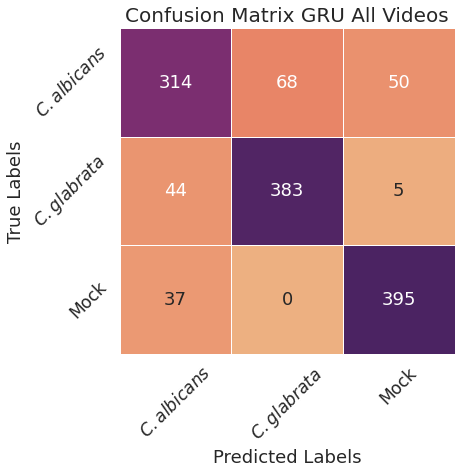

In [27]:
def confusion_matrix_all(original_label,predicted_label,target_names, num, network):
    
    cm = confusion_matrix(original_label,predicted_label)
    cmn = cm.astype('float')/cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots(figsize=(6,6))
    sns.set(font_scale = 1.5)
    image_cm = sns.heatmap(cm, cmap="flare",linewidths= 0.5,
            annot=True,xticklabels=target_names, yticklabels=target_names, cbar=0, fmt = 'g')
    plt.ylabel('True Labels', fontsize = 18)
    plt.xlabel('Predicted Labels', fontsize = 18)
    plt.xticks(rotation = 45, fontsize = 17)
    plt.yticks(rotation = 45,fontsize = 17)
    plt.title(f'Confusion Matrix {network}', fontsize=20)
    plt.show(block=True)
    image_cm.figure.savefig(f'confusion_matrices/{network}_'+str(num)+'.png',dpi=300,bbox_inches='tight')

confusion_matrix_all(orig_all, pred_trans_all, target_names, '0_0', 'Transformers All Videos')
confusion_matrix_all(orig_all, pred_lstm_all, target_names, '0_0', 'GRU All Videos')

In [28]:
from sklearn.metrics import classification_report

# Calculate accuracy, precision, recall, and F1-score
print("\nClassification Report Transformers:")
print(classification_report(orig,pred_trans))

print("\nClassification Report LSTM:")
print(classification_report(orig,pred_lstm))


Classification Report Transformers:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         9
           1       1.00      1.00      1.00         9
           2       1.00      1.00      1.00         9

    accuracy                           1.00        27
   macro avg       1.00      1.00      1.00        27
weighted avg       1.00      1.00      1.00        27


Classification Report LSTM:
              precision    recall  f1-score   support

           0       1.00      0.89      0.94         9
           1       0.90      1.00      0.95         9
           2       1.00      1.00      1.00         9

    accuracy                           0.96        27
   macro avg       0.97      0.96      0.96        27
weighted avg       0.97      0.96      0.96        27



In [29]:
# Calculate accuracy, precision, recall, and F1-score
print("\nClassification Report Transformers All Videos:")
print(classification_report(orig_all, pred_trans_all))

print("\nClassification Report LSTM All Videos:")
print(classification_report(orig_all, pred_lstm_all))


Classification Report Transformers All Videos:
              precision    recall  f1-score   support

           0       0.80      0.76      0.78       432
           1       0.87      0.85      0.86       432
           2       0.87      0.94      0.90       432

    accuracy                           0.85      1296
   macro avg       0.85      0.85      0.85      1296
weighted avg       0.85      0.85      0.85      1296


Classification Report LSTM All Videos:
              precision    recall  f1-score   support

           0       0.79      0.73      0.76       432
           1       0.85      0.89      0.87       432
           2       0.88      0.91      0.90       432

    accuracy                           0.84      1296
   macro avg       0.84      0.84      0.84      1296
weighted avg       0.84      0.84      0.84      1296



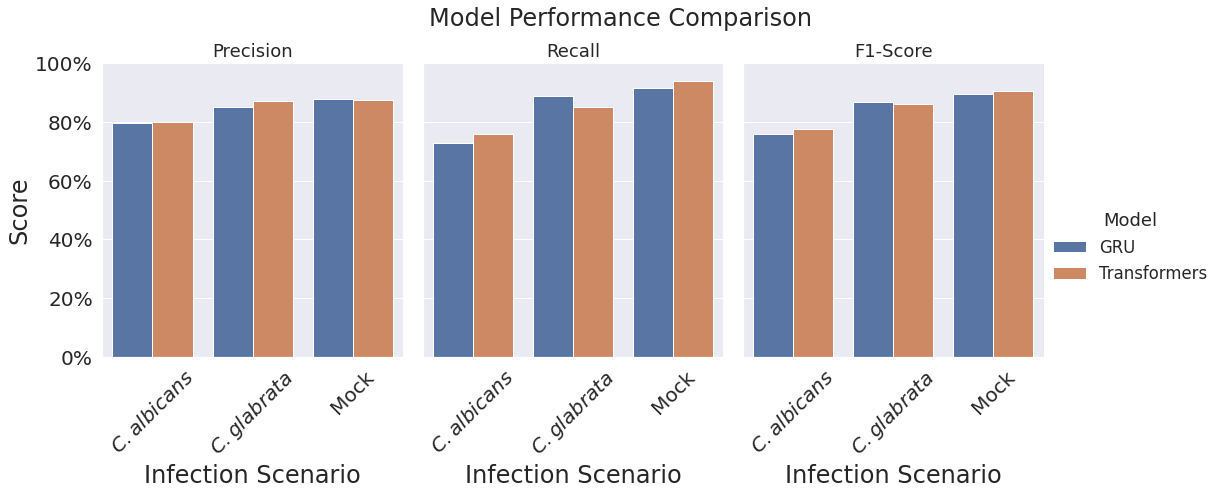

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report

classification_reports = []
report = classification_report(orig_all, pred_lstm_all, output_dict=True)
classification_reports.append(report)
report = classification_report(orig_all, pred_trans_all, output_dict=True)
classification_reports.append(report)

model_names = ['GRU', 'Transformers']

def plot_classification_report_comparison(classification_reports, model_names):
    metrics = ['Precision', 'Recall', 'F1-Score']
    data = []

    for report, model_name in zip(classification_reports, model_names):
        classes = list(report.keys())[:-3]  # Remove 'accuracy', 'macro avg', and 'weighted avg'
        precision = [report[key]['precision'] for key in classes]
        recall = [report[key]['recall'] for key in classes]
        f1_score = [report[key]['f1-score'] for key in classes]

        for i, c in enumerate(classes):
            data.append({'Model': model_name, 'Class': c, 'Metric': 'Precision', 'Value': precision[i]*100})
            data.append({'Model': model_name, 'Class': c, 'Metric': 'Recall', 'Value': recall[i]*100})
            data.append({'Model': model_name, 'Class': c, 'Metric': 'F1-Score', 'Value': f1_score[i]*100})

    df = pd.DataFrame(data)
    df['Class'] = df['Class'].replace({'0': '$\it{C. albicans}$', '1': '$\it{C. glabrata}$', '2': 'Mock'})

    # Plot using Seaborn
    g = sns.catplot(x='Class', y='Value', hue='Model', col='Metric', data=df, kind='bar', height=6, aspect=0.8)
    g.set_titles("{col_name}", fontsize=24)
    g.set_axis_labels('Infection Scenario', 'Score', fontsize=24)  # Change x-label to 'Infection Scenario'
    g.set_xticklabels(fontsize=20, rotation=45)  # Rotate x-labels by 45 degrees
    g.set_yticklabels(fontsize=20)
    g.set(ylim=(0, 100))

    # Format the y-axis ticks as percentages
    for ax in g.axes.flat:
        ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{int(x)}%"))

    plt.subplots_adjust(top=0.85)
    g.fig.suptitle('Model Performance Comparison', fontsize=24)

    # Save the plot as a PNG image with 300 dpi
    plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Call the function to plot the classification report comparison
plot_classification_report_comparison(classification_reports, model_names)

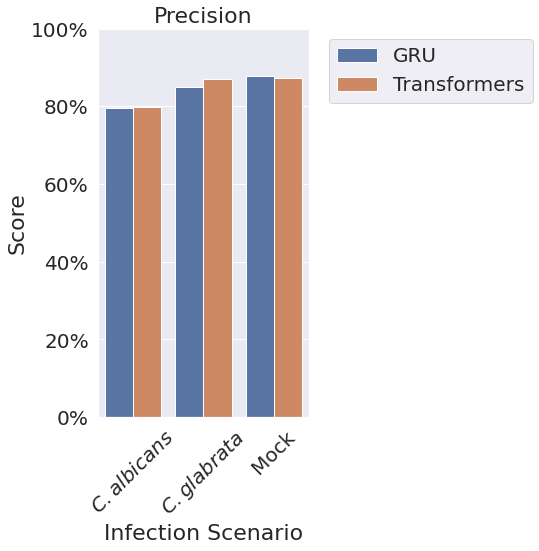

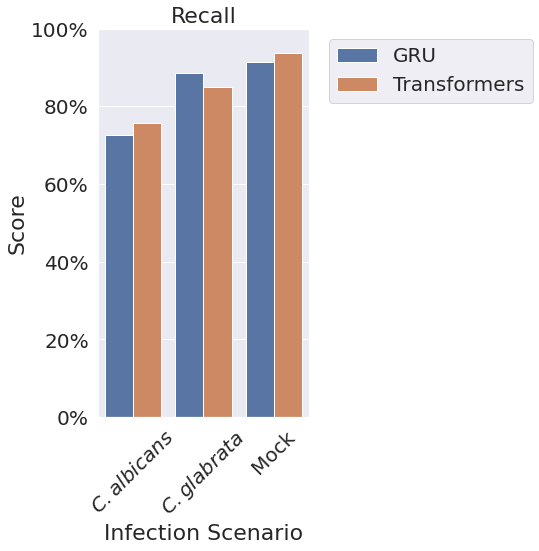

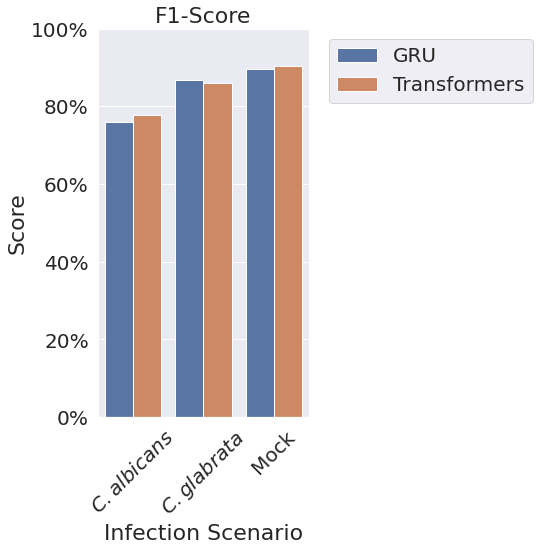

In [38]:
def plot_classification_report_comparison(classification_reports, model_names):
    metrics = ['Precision', 'Recall', 'F1-Score']
    data = []

    for report, model_name in zip(classification_reports, model_names):
        classes = list(report.keys())[:-3]  # Remove 'accuracy', 'macro avg', and 'weighted avg'
        precision = [report[key]['precision'] for key in classes]
        recall = [report[key]['recall'] for key in classes]
        f1_score = [report[key]['f1-score'] for key in classes]

        for i, c in enumerate(classes):
            data.append({'Model': model_name, 'Class': c, 'Metric': 'Precision', 'Value': precision[i]*100})
            data.append({'Model': model_name, 'Class': c, 'Metric': 'Recall', 'Value': recall[i]*100})
            data.append({'Model': model_name, 'Class': c, 'Metric': 'F1-Score', 'Value': f1_score[i]*100})

    df = pd.DataFrame(data)
    df['Class'] = df['Class'].replace({'0': '$\it{C. albicans}$', '1': '$\it{C. glabrata}$', '2': 'Mock'})

    # Create separate plots for each metric
    for metric in metrics:
        plt.figure(figsize=(8, 8))
        sns.barplot(x='Class', y='Value', hue='Model', data=df[df['Metric'] == metric])
        plt.title(f'{metric}', fontsize=22)
        plt.ylabel('Score', fontsize=22)
        plt.xlabel('Infection Scenario', fontsize=22)
        plt.xticks(rotation=45, fontsize=20)
        plt.yticks(fontsize=20)
        plt.ylim(0, 100)

        # Format the y-axis ticks as percentages
        plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, loc: f"{int(x)}%"))

        # Move the legend outside the plot
        plt.legend(fontsize=20, bbox_to_anchor=(1.05, 1), loc='upper left')

        plt.tight_layout()
        # Save each plot as a PNG image with 300 dpi
        plt.savefig(f'model_comparison_{metric}.png', dpi=300, bbox_inches='tight')
        plt.show()

# Call the function to plot the classification report comparison
plot_classification_report_comparison(classification_reports, model_names)